In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break
    break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install torchsummary

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torchaudio
import pandas as pd
import os
from torch import nn
from torchsummary import summary
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
LABEL_MAP = [
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark",
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
]

In [5]:
mel_spectrogram_transforms = torchaudio.transforms.MelSpectrogram(
    sample_rate = SAMPLE_RATE,
    n_fft = 1024,
    hop_length = 512,
    n_mels = 64
)

In [6]:
class UrbanSoundDataset(Dataset):
    def __init__(self,
       annotations_file,
       audio_dir,
       train,
       transformation = mel_spectrogram_transforms,
       target_sample_rate = SAMPLE_RATE,
       num_samples = NUM_SAMPLES,
       device = 'cpu'):
        self.device = device
        self.annotations = pd.read_csv(annotations_file)
        if train:
            self.annotations = self.annotations.iloc[:7000]
        else :
            self.annotations = self.annotations.iloc[7000:]
        self.audio_dir = audio_dir
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,idx):
        sample_path = self._get_sample_path(idx)
        label = self._get_sample_label(idx)
        signal, sr = torchaudio.load(sample_path)
        signal = signal.to(self.device)
        signal = self._fix_sample_rate(signal,sr)
        signal = self._fix_channels(signal)
        signal = self._fix_num_samples(signal)
        signal = self.transformation(signal)
        return signal,label

    def _fix_num_samples(self,signal):
        # Cut if needed
        if signal.shape[1] > self.num_samples:
            signal = signal[:,:self.num_samples]
        if signal.shape[1] < self.num_samples:
            difference = self.num_samples - signal.shape[1]
            padding = (0,difference)
            signal = torch.nn.functional.pad(signal,padding)
        return signal

    def _fix_sample_rate(self,signal,sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr,self.target_sample_rate).to(device)
            signal = resampler(signal)
        return signal

    def _fix_channels(self,signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal,dim=0,keepdim=True)
        return signal

    def _get_sample_path(self,idx):
        fold = f"fold{self.annotations.iloc[idx,5]}"
        path = os.path.join(self.audio_dir,fold,self.annotations.iloc[idx,0])
        return path

    def _get_sample_label(self,idx):
        return self.annotations.iloc[idx,6]

In [7]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128*4*5,512)
        self.linear2 = nn.Linear(512,128)
        self.linear3 = nn.Linear(128,32)
        self.linear4 = nn.Linear(32,10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self,input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        logits = self.linear4(x)
        predictions = self.softmax(logits)
        return predictions

In [8]:
def train_epoch(model,data_loader,loss_fn,optimiser,device):
    model.train()
    total_loss = 0
    for (X,Y) in data_loader:
        X,Y = X.to(device),Y.to(device)
        predictions = model(X)
        loss = loss_fn(predictions,Y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f"\t\tloss : {avg_loss}",end="")

In [9]:
def predict(model,input):
    model.eval()
    with torch.no_grad():
        A = model(input)
        predictions = A.argmax(dim=1)
    return predictions

In [10]:
def getAccuracy(predictions,Y):
    return torch.mean((predictions == Y).type(torch.float)).item() * 100

In [11]:
def test(model,data_loader,device,testing=True):
    accuracy_total = 0
    for (X,Y) in data_loader:
        X,Y = X.to(device),Y.to(device)
        predictions = predict(model,X)
        accuracy_total += getAccuracy(predictions,Y)
        accuracy = accuracy_total / len(data_loader)
    print(f"\n{'test' if testing else 'train'} accuracy : {accuracy:.2f}%",end="")

In [12]:
def train(model,train_data_loader,loss_fn,optimiser,device,epochs,test_data_loader=None):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_epoch(model,train_data_loader,loss_fn,optimiser,device)
        print("\n--------------------------")
    print("Done")

In [13]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [14]:
annotations_path = rf"/kaggle/input/urbansound8k/UrbanSound8K.csv"
audio_path = rf"/kaggle/input/urbansound8k"

In [15]:
train_dataset = UrbanSoundDataset(annotations_path,audio_path,train=True,device=device)
test_dataset = UrbanSoundDataset(annotations_path,audio_path,train=False,device=device)

In [16]:
BATCH_SIZE = 64
train_data_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE)
test_data_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE)

In [17]:
train_dataset[0][0].shape

torch.Size([1, 64, 44])

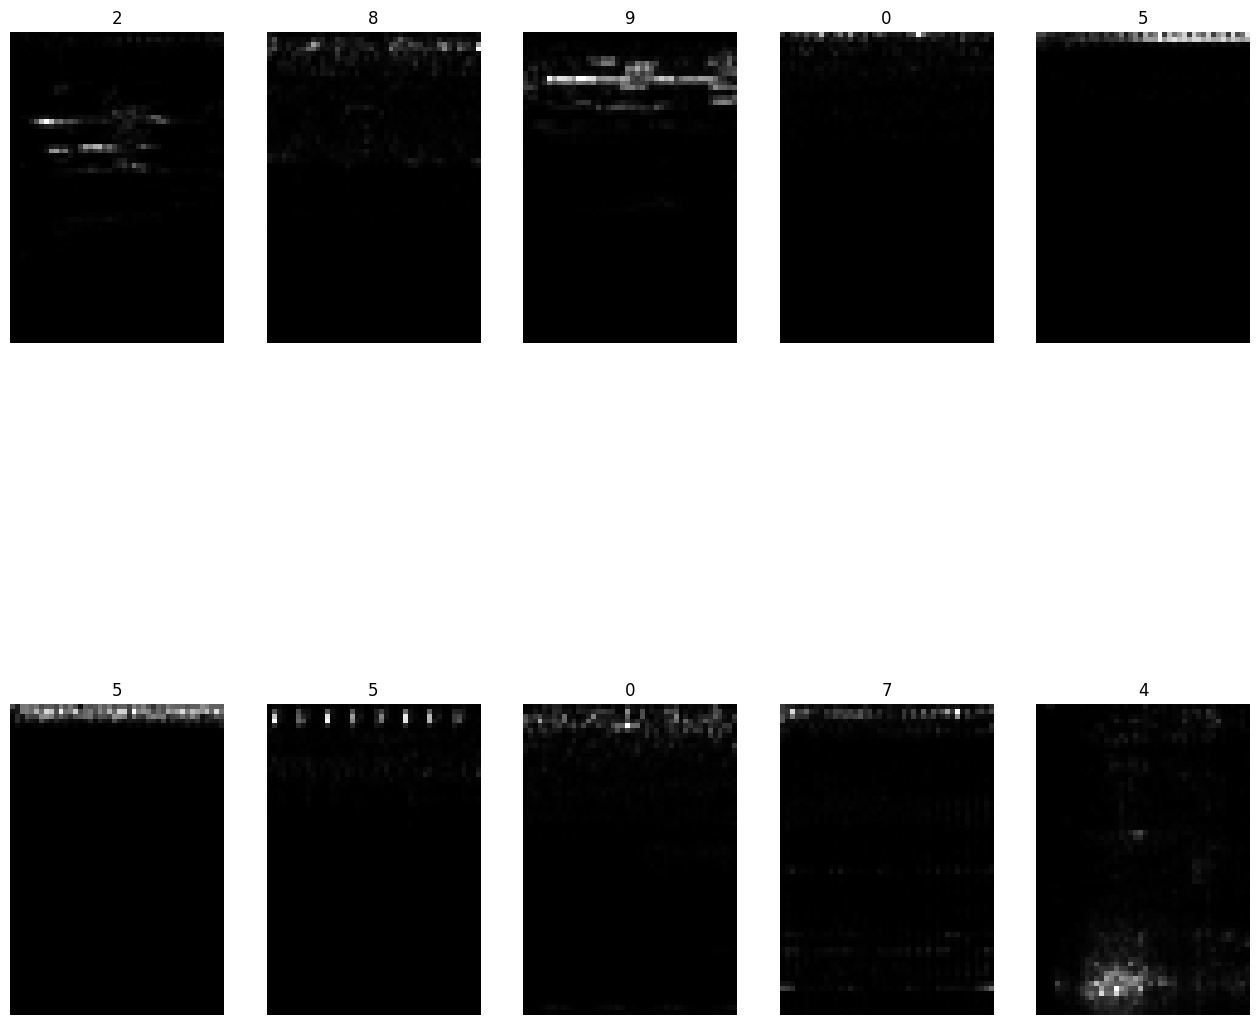

In [18]:
figure = plt.figure(figsize=(16,16))
rows,cols = 2,5
for i in range(1,rows*cols + 1):
    idx = torch.randint(len(train_dataset)-1,size=(1,)).item()
    X,Y = train_dataset[idx][0].squeeze(),train_dataset[idx][1].item()
    img,label = X.to('cpu'),Y
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [19]:
MODEL_PATH = "/kaggle/input/urbansound8k_model/pytorch/default/1/model_best2.pt"

In [20]:
model = CNNNetwork()
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.0001)
EPOCHS = 300

In [22]:
train(model,train_data_loader,loss_fn,optimiser,device,EPOCHS,test_data_loader)

Epoch 1
		loss : 1.8416224230419507
--------------------------
Epoch 2
		loss : 1.8121805689551613
--------------------------
Epoch 3
		loss : 1.8078665083104914
--------------------------
Epoch 4
		loss : 1.822783508084037
--------------------------
Epoch 5
		loss : 1.8144109270789406
--------------------------
Epoch 6
		loss : 1.8072362032803622
--------------------------
Epoch 7
		loss : 1.8056474317203868
--------------------------
Epoch 8
		loss : 1.7962064710530368
--------------------------
Epoch 9
		loss : 1.7989374041557311
--------------------------
Epoch 10
		loss : 1.7933166297999295
--------------------------
Epoch 11
		loss : 1.8159915577281605
--------------------------
Epoch 12
		loss : 1.7989817771044645
--------------------------
Epoch 13
		loss : 1.829244432666085
--------------------------
Epoch 14
		loss : 1.7982686519622804
--------------------------
Epoch 15
		loss : 1.8052576531063427
--------------------------
Epoch 16
		loss : 1.802329952066595
---------------

In [23]:
test(model,train_data_loader,device,testing=False)
test(model,test_data_loader,device)


train accuracy : 85.98%
test accuracy : 50.89%

In [24]:
SAVE_PATH = '/kaggle/working/model_best2.pt'

In [25]:
torch.save(model.state_dict(),SAVE_PATH)